In [1]:
%matplotlib inline

import sys
sys.path.append('/home/ngr4/project/scgat/scripts/')
import utils as scgatutils
# import models as scgatmodels
import models_dev as scgatmodels
import load_data as scgatdata

import os
import glob
import scanpy as sc
import numpy as np
import pandas as pd
from scipy.stats import gaussian_kde
import seaborn as sns 
import matplotlib.pyplot as plt
import time 
import datetime
import pickle



# settings
plt.rc('font', size = 9)
plt.rc('font', family='sans serif')
plt.rcParams['pdf.fonttype']=42
plt.rcParams['ps.fonttype']=42
plt.rcParams['legend.frameon']=False
plt.rcParams['axes.grid']=False
plt.rcParams['legend.markerscale']=0.5
plt.rcParams['savefig.dpi']=600
sns.set_style("ticks")

/gpfs/ysm/project/dijk/ngr4/conda_envs/py38dev/lib/python3.8/site-packages/torch/cuda/__init__.py:52: UserWarning: CUDA initialization: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx (Triggered internally at  /opt/conda/conda-bld/pytorch_1607370117127/work/c10/cuda/CUDAFunctions.cpp:100.)
  return torch._C._cuda_getDeviceCount() > 0


In [2]:
datapkl = '/home/ngr4/project/scgat/data/processed/rvcse_ycondition.pkl'

# load data
data = scgatutils.load_datapkl(datapkl)
adata = data['adata']

In [3]:
adata

AnnData object with n_obs × n_vars = 24767 × 23529
    obs: 'batch', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'pmito', 'n_genes', 'split', 'y_condition'
    var: 'gene_ids', 'feature_types', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells'
    uns: 'pca', 'neighbors', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

In [110]:
# need to recalculate 
sc.tl.leiden(adata, resolution=0.5)

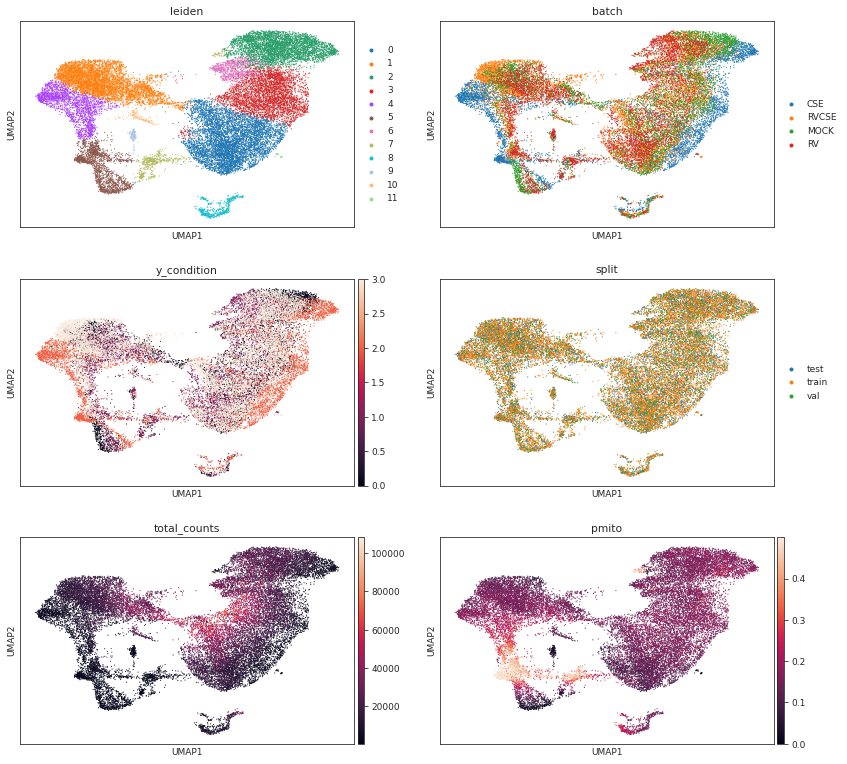

In [111]:
sc.pl.umap(adata, color=['leiden', 'batch', 'y_condition', 'split', 'total_counts', 'pmito'], ncols=2)

In [112]:
# REF: https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5135277/ (most lung tissue markers come from here)
cell_markers = {'Basal': ['KRT5', 'DAPL1', 'TP63'],
                'Basal (proliferating)': ['ADH7', 'MKI67', 'TOP2A', 'CDK1'],
                'Hillock': ['KRT4', 'KRT13'],
                'Club': [ 'KRT15', 'CD74','CXCL6'],
                'Ciliated': ['FOXJ1', 'CCDC153', 'CCDC113', 'MLF1', 'LZTFL1','TUBB1','TP73','CCDC78'],
                'Tuft': ['POU2F3', 'AVIL', 'MAFF','MIAT','NOS2'],
                'Ionocyte': ['FOXI1', 'CFTR', 'ASCL3'], 
                'Goblet': ['MUC5AC', 'MUC5B', 'SPDEF'],
                'Epithelial':['ABCA3','LPCAT1','NAPSA','SFTPB','SFTPC','SLC34A2'],
                'Neuroendocrine':['ACADSB','ADA','AFAP1','CPE'],
                'Dendritic':['ITGAX','CCR7','CD207', 'LY75'], # missing 
#                 'Macrophage':['CD68','CD14','CCL18','CD163'],
                'Endothelial':['CD34','PECAM1','VWF'],
                'Fibroblast':['THY1','CD36','PDGFRA','PTPN13'],
                'Tcell':['CD3E','CD3D','CD3G','CD8A','CD8B','CD4'],
                'Granulocyte':['CCR5','SMAD1','ITGAM'],
#                 'Alveolar':['SLC34A2','ABCA3','CD44'],
                'AT1':['SLC34A2','ABCA3','CD44','AGER','PDPN','CLIC5'],
                'AT2':['SLC34A2','ABCA3','CD44','SFTPB','SFTPC','SFTPD','MUC1'],
                'Myofibroblast':['ACTA2'],
                'Monocyte':['CD36','CD14','CD68'],
                'NK':['NCR1'],
                'Progenitor':['TM4SF1','CEACAM6'],
#                 'Neutrophil':['S100A9','S100A8','S100A12','VCAN','FCN1',
#                               'CSTA','TSPO','CD14','MNDA','CTSD','PLBD1'], # from Tianyang (Iwasaki lab) ORIGINAL
                'Eosinophil':['RNASE2','LGALS1','RETN','AC020656.1', 
                              'H1FX','SLC44A1','AL355922.1','RFLNB','SERPINB10', 'RNASE3'], # from Tianyang (Iwasaki lab) ORIGINAL
#                 'Macrophage':['S100A9','S100A8','FCGR3A','CD14','CD68','FCGR1A','MARCO','MSR1','MRC1','C1QB','C1QA','FABP4','APOC1','APOE','PPARG'],
#                 'Monocyte':['S100A9','S100A8','FCGR3A','CD14','CD68','FCGR1A','RNASE2','RNASE3','FCN1','TNFRSF1B','S100A12','VCAN','CCR2','SDS'],
#                 'Monocyte':['CCR2', 'FCN1', 'RNASE2', 'RNASE3', 'S100A12', 'SDS', 'TNFRSF1B', 'VCAN'], # no overlap btw Macrophage/Monocyte/Neutrophil
                'Monocyte':['CCR2', 'FCN1', 'RNASE2', 'S100A12', 'SDS', 'TNFRSF1B', 'VCAN'],
                'Macrophage':['APOC1', 'APOE', 'C1QA', 'C1QB', 'FABP4', 'MARCO', 'MRC1', 'MSR1', 'PPARG'], # no overlap btw Macrophage/Monocyte/Neutrophil
                'Neutrophil':['CEACAM1', 'CEACAM8', 'CSF3R', 'CXCR1', 'CXCR2', 'FCGR3B'], # no overlap btw Macrophage/Monocyte/Neutrophil
#                 'Neutrophil':['S100A9','S100A8','FCGR3A','CEACAM8','CXCR1','CXCR2','CEACAM1','FCGR3B','CSF3R'],
#                 'Eosinophil':['RNASE2','RNASE3','IL5RA','CCR3','EPX','PRG2','PRG3','PTGDR2','SIGLEC8','GATA2'], # don't use RNASE2/3 since they overlap
#                 'Eosinophil':['IL5RA','CCR3','PRG2','PTGDR2','SIGLEC8','GATA2'], # don't use RNASE2/3 since they overlap
#                 'Eosinophil':['IL5RA','CCR3','PRG2','PTGDR2','SIGLEC8','GATA2', 'EPO','CD9','RNASE3','RETN','H1FX','RFLNB'], # added EPO and CD9 <>                
               }

In [113]:
def getX(adata, cell_markers, remove_missing_markers=False, verbose=True):
    '''Subset adata to markers
    
    Arguments:
      adata (sc.AnnData)
      cell_markers (dict)
      
    Returns:
      pd.DataFrame (m cells x n genes)
      dict (cell_markers returned, since it may change in fx)
    '''
    from scipy.stats import zscore 
    
    genes = [g for k,v in cell_markers.items() for g in v]
    not_in_adata = [g for g in genes if not g in adata.var_names]
    if len(not_in_adata) > 0:
        if verbose:
            print('Some genes not in adata obj. Cannot subset.')
        if remove_missing_markers:
            if verbose:
                print('  Removing from cell_markers:')
            for g in not_in_adata:
                for k,v in cell_markers.items():
                    new_markers = []
                    for gg in v:
                        if gg!=g:
                            new_markers.append(gg)
                    if len(new_markers) >0 and len(new_markers) <= 2 and verbose:
                        print('  !!Consider adding more markers for {} (only {} in dict)'.format(k, len(new_markers)))
                    if len(new_markers) == 0:
                        print('WARNING: {} will be removed as a cell type because there are no markers in adata'.format(k))
                    cell_markers[k] = new_markers
                    if verbose:
                        print('    {}\tgroup: {}'.format(g, k))
            if verbose:
                print('\n... new cell_markers:')
                print(cell_markers)
            cell_markers = {k:v for k,v in cell_markers.items() if len(v)>0}
            genes = [g for k,v in cell_markers.items() for g in v] # update genes
        else:
            print('  Fix the following missing:')
            for g in not_in_adata:
                for k,v in cell_markers.items():
                    for gg in v:
                        if gg==g:
                            print('    {}\tgroup: {}'.format(g, k))
            print('\n  ... exiting.')
            return None   
    
    # subset
    x = pd.DataFrame(adata[:,genes].X.todense(), columns=genes)
    x['cluster'] = adata.obs['leiden'].to_list()
    add_pcs = True
    if add_pcs:
        pcs = ['PC1','PC2'] # can add more 
        for i,pc in enumerate(pcs):       
            x[pc] = adata.obsm['X_pca'][:,i]
        genes = genes + pcs

    # standard scale
    x.loc[:,genes] = zscore(x.loc[:,genes])
    
    return x, cell_markers

In [114]:
x, cell_markers = getX(adata, cell_markers, remove_missing_markers=True, verbose=False)

/gpfs/ysm/project/dijk/ngr4/conda_envs/py38dev/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


In [115]:
def cluster2ctype(adata, x, cell_markers, ORthreshold=0.9, out_file=None, verbose=True, add_pcs=True):
    from sklearn.linear_model import LogisticRegression
    from sklearn import metrics
    import time
    import re
    
    if verbose:
        tic = time.time()
        counter = 0
        total_iter = len(cell_markers.keys())*len(x['cluster'].unique())
        print('Lasso logistic regression...')
    
    results = pd.DataFrame()
    new_markers = {}
    
    for i,ctype in enumerate(cell_markers.keys()):
        for j,cluster in enumerate(x['cluster'].unique()):
            if verbose:
                if counter % 50 == 0 and counter != 0:
                    p_through = counter / total_iter
                    toc = time.time() - tic
                    print('  through {:.1f}-% in {:.2f}-s\t~{:.2f}-s remain'.format(100*p_through,toc,(toc/counter)*(total_iter-counter)))

            # binarize & subset
            y = (x['cluster']==cluster).astype(int)
            pcs = [iii for ii in [re.findall('^PC\d', i) for i in x.columns if len(re.findall('^PC\d', i))>0] for iii in ii]
            if add_pcs:
                X = x.loc[:,cell_markers[ctype]+pcs]
            else:
                X = x.loc[:,cell_markers[ctype]]

            # run default params (could add CV)
            ## results, solver='saga', time for ~25k cells: >>1min
            ## results, solver='lbfgs', time for ~25k cells: 14s
            ## results, solver='liblinear', time for ~25k cells: 25s
            model = LogisticRegression(max_iter=10000, 
                                       penalty='l1',
                                       tol=1e-6,
                                       solver='liblinear') #n_jobs=-1 doesn't work for liblinear
            model.fit(X, y) 

            status = 'OK'
            if any(np.exp(model.coef_)[0][:-len(pcs)] < ORthreshold):
                markers = [marker for i,marker in enumerate(cell_markers[ctype]) if i not in np.where(np.exp(model.coef_)[0][:-len(pcs)]<0.9)[0]]
                if len(markers) != 0:
                    new_markers[ctype] = markers
                    if add_pcs:
                        X = x.loc[:,markers+pcs]
                    else:
                        X = x.loc[:,markers]
                    model = LogisticRegression(max_iter=10000, 
                                       penalty='l1',
                                       tol=1e-6,
                                       solver='liblinear') #n_jobs=-1 doesn't work for liblinear
                    model.fit(X, y)
                else:
                    status = 'No markers with ORs >= {}'.format(ORthreshold)
            else: 
                markers = cell_markers[ctype]

            # eval metrics
            p1 = model.predict_proba(X)[:,1]
            fpr, tpr, thresholds = metrics.roc_curve(y, p1)
            optimal_idx = np.argmax(tpr-fpr)
            optimal_threshold = thresholds[optimal_idx]
            optimal_pred = (p1>optimal_threshold).astype(int)
            precision,recall,_ = metrics.precision_recall_curve(y, p1)
            auprc = metrics.auc(recall, precision)
            auroc = metrics.roc_auc_score(y,p1)
            ap = metrics.average_precision_score(y,p1)
            bs = metrics.brier_score_loss(y,p1)
            acc = metrics.accuracy_score(y,optimal_pred)

            # store results
            dt = pd.DataFrame({'ctype2pred':ctype,
                               'cluster':cluster,
                               'auroc':auroc,
                               'status':status,
                               'markers':[markers],
                               'ORs':np.exp(model.coef_).tolist(),
                               'ave_prec':ap,
                               'acc':acc,
                               'sensitivity':tpr[optimal_idx],
                               'specificity':1-fpr[optimal_idx]},
                              index=[0])
            results = results.append(dt, ignore_index=True)
            counter += 1
    print('Classifiers done. Saving and plotting...')  

    top_per_ctype = pd.DataFrame()
    top_n = 3
    for ctype in results['ctype2pred'].unique():
        dt = results.loc[results['ctype2pred']==ctype,:]
        dt = dt.sort_values(by='auroc', ascending=False)
        top_per_ctype = top_per_ctype.append(dt.iloc[0:top_n,:], ignore_index=True)

    top_per_cluster = pd.DataFrame()
    top_n = 3
    for cluster in results['cluster'].unique():
        dt = results.loc[results['cluster']==cluster,:]
        dt = dt.sort_values(by='auroc', ascending=False)
        top_per_cluster = top_per_cluster.append(dt.iloc[0:top_n,:], ignore_index=True)

    if out_file is not None:
        top_per_cluster.to_csv(out_file)

    # annotate with top cluster
    top1_per_cluster = pd.DataFrame()
    for cluster in results['cluster'].unique():
        dt = results.loc[results['cluster']==cluster,:]
        dt = dt.sort_values(by='auroc', ascending=False)
        if True:
            # eliminate rows with poor status (no markers with OR>=threshold)
            dt = dt.loc[dt['status'] == 'OK',:]
        if dt.shape[0]==0:
            print('Cluster {} could not be annotated due to ORs of markers.'.format(cluster))
            continue
        top1_per_cluster = top1_per_cluster.append(dt.iloc[0:1,:], ignore_index=True)
    ctype_annotation = {}
    for cluster in top1_per_cluster['cluster']:
        ctype_annotation[cluster] = top1_per_cluster.loc[top1_per_cluster['cluster']==cluster,'ctype2pred'].values[0]
    adata.obs['cluster2ctype'] = adata.obs['leiden'].astype(str)
    adata.obs['cluster2ctype'] = adata.obs['cluster2ctype'].map(ctype_annotation)

    if verbose:
        ## plot
        sc.pl.umap(adata, color=['leiden', 'cluster2ctype'])

        # print bad ones
        print('\nClusters hard to identify')
        print('-------------------------')

        underdetermined = top1_per_cluster.loc[top1_per_cluster['auroc'] <= 0.7, :]
        for i in range(underdetermined.shape[0]):
            print(underdetermined.iloc[i,:])
            
    return adata, results
        


Lasso logistic regression...
  through 18.1-% in 14.21-s	~64.22-s remain
  through 36.2-% in 30.56-s	~53.78-s remain
  through 54.3-% in 45.15-s	~37.93-s remain
  through 72.5-% in 67.01-s	~25.46-s remain
  through 90.6-% in 79.49-s	~8.27-s remain


... storing 'cluster2ctype' as categorical


Classifiers done. Saving and plotting...


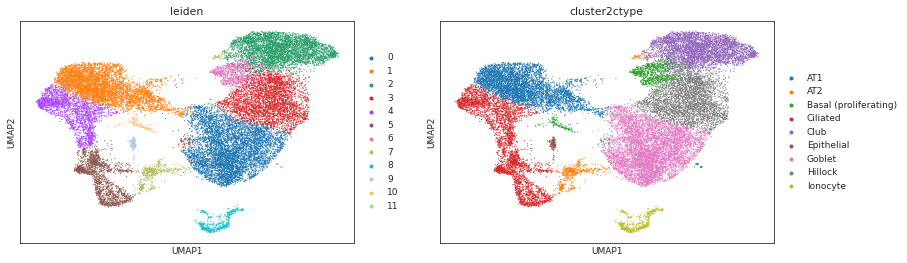


Clusters hard to identify
-------------------------


In [116]:
adata, results = cluster2ctype(adata, x, cell_markers, out_file='/home/ngr4/project/scgat/results/rvcse_cluster2ctype_results.csv')